## Lab 3: Topic Models
### 732A92/TDDE16 Text Mining

In [61]:
import numpy, random, scipy.special
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

class MyGibbs(object):
    def __init__(self,
                 num_topics,
                 docs_file_name,
                 stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.doc_snippets = []
        self.docs = []

        ## Prepare list of stopwords
        self.stoplist = dict()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stoplist[word] = 1

        self.read_documents(docs_file_name)
        self.initialize_matrices()

    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics))
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics))
        self.topic_totals = numpy.zeros(self.num_topics)
        self.doc_totals = numpy.zeros(self.num_docs)

        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = list(map(lambda x: random.randrange(self.num_topics), doc['tokens']))
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for i in range(doc_length):
                token = doc['tokens'][i]
                topic = doc['topics'][i]
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1

    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}

        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []

                for w in line.split():
                    if not w in self.stoplist:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)

                self.doc_snippets.append(line[:200])
                self.docs.append({ 'tokens': tokens })

        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))

    def make_draw(self, alpha, beta):
        """Makes a single draw from the posterior distribution in an MCMC fashion."""
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            doc_tokens = doc["tokens"]
            doc_topics = doc["topics"]

            for idx, (token, topic) in enumerate(zip(doc_tokens, doc_topics)):
                self.term_topics[token][topic] -= 1
                self.doc_topics[doc_id][topic] -= 1
                self.topic_totals[topic] -= 1

                topic_probs = self._compute_topic_probs(doc_id, token, alpha, beta)
                new_topic = self._sample_topic(topic_probs)

                doc_topics[idx] = new_topic
                self.term_topics[token][new_topic] += 1
                self.doc_topics[doc_id][new_topic] += 1
                self.topic_totals[new_topic] += 1

        self.phi = numpy.array(self.term_topics).T
        self.phi += beta
        self.phi = normalize(self.phi, axis=1, norm="l1")
        
        return self

    def _compute_topic_probs(self, doc, token, alpha, beta):
        probs = [0] * self.num_topics

        for topic in range(self.num_topics):
            factor1 = alpha + self.doc_topics[doc][topic]
            factor2 = beta + self.term_topics[token][topic]
            factor3 = beta * len(self.vocab) + self.topic_totals[topic]
            probs[topic] = factor1 * factor2 / factor3

        return probs / sum(probs)

    def _sample_topic(self, topic_probs):
        return numpy.random.choice(self.num_topics, size=1, p=topic_probs)[0]

    def compute_logprob(self, alpha, beta):
        """Computes the log marginal posterior."""
        K = self.num_topics
        V = self.num_terms
        D = self.num_docs

        KV = K * V
        DK = D * K
        VB = V * beta
        KA = K * alpha

        lg = scipy.special.gammaln

        term1 = K * lg(VB)
        term2 = -KV * lg(beta)

        term3 = 0
        for topic in range(K):
            for word in range(V):
                term3 += lg(self.term_topics[word][topic] + beta)

        term4 = 0
        for topic in range(K):
            inner_sum = 0
            for word in range(V):
                inner_sum += self.term_topics[word][topic]
            term4 += lg(inner_sum + beta)
        term4 *= -1

        term5 = D * lg(KA)
        term6 = -DK * lg(alpha)

        term7 = 0
        for doc in range(D):
            for topic in range(K):
                term7 += lg(self.doc_topics[doc][topic] + alpha)

        term8 = 0
        for doc in range(D):
            inner_sum = 0
            for topic in range(K):
                inner_sum += self.doc_topics[doc][topic]
            term8 += lg(inner_sum + alpha)
        term8 *= -1

        return term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8

    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []

        for iteration in range(num_iterations):
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            # print("iteration {}, {}".format(iteration, logprob))

    def print_topics(self, j):
        """Prints topic distributions for the."""
        topic_term = numpy.array(self.term_topics).T
        for topic in range(self.num_topics):
            print("Topic %i:" % (topic + 1,), end=" ")
            for word in numpy.argsort(topic_term[topic, :])[-j:]:
                print(self.vocab[word], end=" ")
            print()

    def plot(self):
        plt.plot(self.logprobs)
        plt.ylabel("Log Probability")
        plt.xlabel("# of iterations")
        plt.show()
        
    def new_speech(self, length):
        """Samples a new speech of the given length."""
        
        def sample_word(probs):
            return numpy.random.choice(self.num_terms, size=1, p=probs)[0]

        theta = numpy.random.dirichlet(alpha=[0.5] * self.num_topics)
        speech = [None] * length

        for i in range(length):
            topic = self._sample_topic(theta)
            word = sample_word(self.phi[topic,:])
            speech[i] = self.vocab[word]

        return " ".join(speech)

### 1. Sampling

Read 2898 documents with a total of 8695 terms


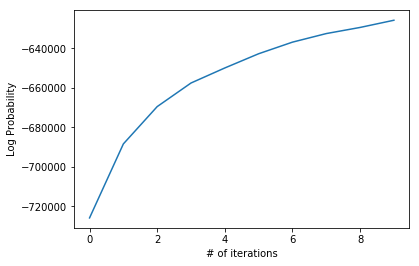

In [62]:
model = MyGibbs(10, '../data/sotu_1975_2000.txt', '../data/stoplist_en.txt')
model.run(10)
model.plot()

### 2. Top terms

In [63]:
model.print_topics(10)

Topic 1: local military budget state program space government national years federal 
Topic 2: long system states private work welfare people social year security 
Topic 3: god years time american high care america americans family health 
Topic 4: spending billion federal percent years government energy tax budget year 
Topic 5: administration health nation bring people care support make government families 
Topic 6: system world families nation america work country congress children people 
Topic 7: crime congress century year make work american america americans people 
Topic 8: war union years security people nation freedom peace world america 
Topic 9: war international trade nuclear peace nations soviet economic america world 
Topic 10: countries service time members continue policy federal mr president congress 


### 3. Explore the data

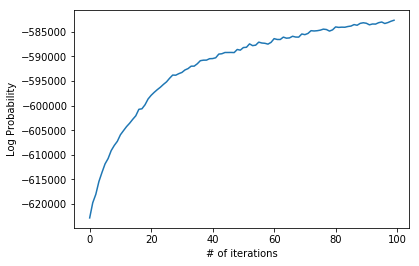

In [64]:
%matplotlib inline
model.run(100)
model.plot()

It looks like it is starting to converge after 100 iterations, but it should probabily run for 1000-2000 iteration to be more certain when it converges. However, the implementation is too slow for that in a reasonable amount of time.

In [65]:
model.print_topics(10)

Topic 1: resources local space program national development programs administration government federal 
Topic 2: provide private program congress programs security social reform welfare system 
Topic 3: families life child people americans year children family health care 
Topic 4: growth billion million federal energy percent year years tax budget 
Topic 5: ll time economy put year make congress people government american 
Topic 6: hard stop united america good country years ve states people 
Topic 7: parents school give schools crime america make education work children 
Topic 8: americans union peace future american nation freedom people world america 
Topic 9: trade economic states united peace security nations nuclear soviet world 
Topic 10: members women nation food mr rights administration president policy congress 


We can kind of interpret some of the topics. For instance topic 3 seem to be about the american people and the health care system. Topic 7 is about education, topic 10 about womens right to vote, and topic 9 is mixed with economical and security terms. Other topics are more difficult to interpret such as topic 5 and 6.

Overall, the topics do seem to capture what you might expect to find from speeches made by the Presidents of the United States.

### 4. Simulate a new State of the Union speech

In [69]:
model.new_speech(100)

'surely raised morning americans refused created laws god care preliminary legislation hundred fellow division businesslike resolution 97th dependable evidence fellow impose source policy costs coordinator time small families house flag breakdown restrictions work formulated life rights tonight messages house pursuit people implement destroyer message day members rights equip chief national achievements organization fairer environment pressures expenditure legal fundamental unfair effort cubans challenge partisan commission action agree enable similar vitality havel sugar chamber dangers narcotic government activities coverage producers year schuller control mistakes president equal desert national control century homebuyers prices house equivalent dr democracy year line defense franklin civil easier'

Having $\alpha = 0.5$ is not completely unreasonable in our opinion. We would like for the speech to be coherent, that is, having few topics so we would not want it to have completely uniform topic ditribution ($\alpha = 1$). By having $\alpha$ in the middle of 0.1 och 1 is reasonable under the assumption that a speech should contain a few number of topics with equally high probability.  